# ===============================================================
# 🔹 EJERCICIO 3: ANÁLISIS DE SENTIMIENTOS EN RESEÑAS DE PRODUCTOS AMAZON
# Dataset: Amazon Fine Food Reviews (Kaggle)
# Objetivo: Clasificar reseñas como positivas o negativas a partir del texto
# ===============================================================

# ===============================================================
# 1. DESCARGA E IMPORTACIÓN DEL DATASET DESDE KAGGLE
# ===============================================================

In [ ]:
!pip install kaggle --quiet

In [ ]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle datasets download -d snap/amazon-fine-food-reviews
!unzip amazon-fine-food-reviews.zip

Dataset URL: https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews
License(s): CC0-1.0
 72% 174M/242M [00:00<00:00, 1.75GB/s]
100% 242M/242M [00:00<00:00, 1.05GB/s]
Archive:  amazon-fine-food-reviews.zip
  inflating: Reviews.csv             
  inflating: database.sqlite         
  inflating: hashes.txt              


# ===============================================================
# 2. CARGA INICIAL Y EXPLORACIÓN BÁSICA DEL DATASET
# ===============================================================

In [ ]:
import pandas as pd

# Cargar el dataset
df = pd.read_csv('Reviews.csv')

# Mostrar dimensiones y primeras filas
print("Dimensiones del dataset:", df.shape)
df.head()

Dimensiones del dataset: (568454, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# ===============================================================
# 3. SELECCIÓN DE VARIABLES Y CREACIÓN DE ETIQUETAS
# ===============================================================

In [ ]:
df = df[['Text', 'Score']].dropna()
df = df[df['Score'] != 3]  # eliminamos reseñas neutras
df['label'] = df['Score'].apply(lambda x: 1 if x >= 4 else 0)
df.head()

,Text,Score,label
0,I have bought several of the Vitality canned d...,5,1
1,Product arrived labeled as Jumbo Salted Peanut...,1,0
2,This is a confection that has been around a fe...,4,1
3,If you are looking for the secret ingredient i...,2,0
4,Great taffy at a great price. There was a wid...,5,1


# ===============================================================
# 4. LIMPIEZA Y VECTORIZACIÓN DEL TEXTO (STOPWORDS, TOKENIZACIÓN Y TF-IDF)
# ===============================================================

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Descargar recursos necesarios
nltk.download('stopwords')

# Función de limpieza
def limpiar_texto(texto):
    texto = texto.lower()                             # minúsculas
    texto = re.sub(r'[^a-z\s]', '', texto)            # solo letras y espacios
    palabras = texto.split()
    palabras = [p for p in palabras if p not in stopwords.words('english')]
    return ' '.join(palabras)

# Aplicar limpieza (esto puede tardar un poco)
df['clean_text'] = df['Text'].apply(limpiar_texto)

# División en train/test
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_text'], df['label'], test_size=0.2, random_state=42
)

# Vectorización TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print("Dimensiones TF-IDF:", X_train_tfidf.shape)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Dimensiones TF-IDF: (420651, 5000)


# ===============================================================
# 5. ENTRENAMIENTO Y EVALUACIÓN DE MODELOS SUPERVISADOS
# (Naive Bayes, Logistic Regression y SVM)
# ===============================================================

Resultados comparativos:

Naive Bayes -> Accuracy: 0.8819, F1: 0.9343
Logistic Regression -> Accuracy: 0.9307, F1: 0.9597
SVM -> Accuracy: 0.9322, F1: 0.9604


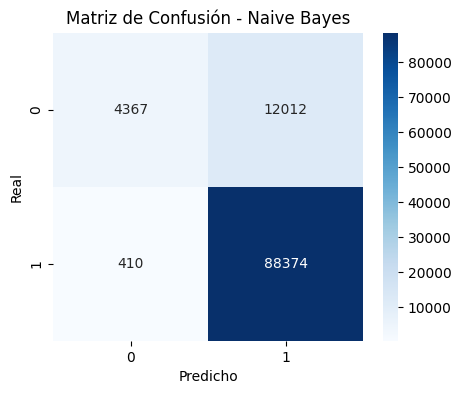

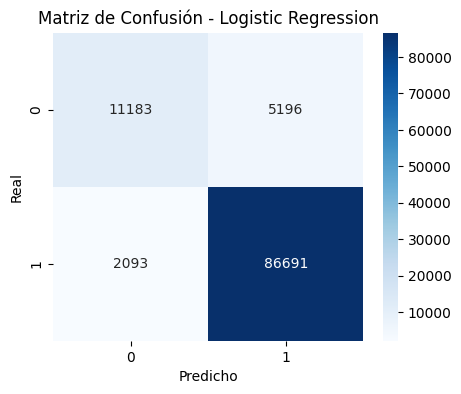

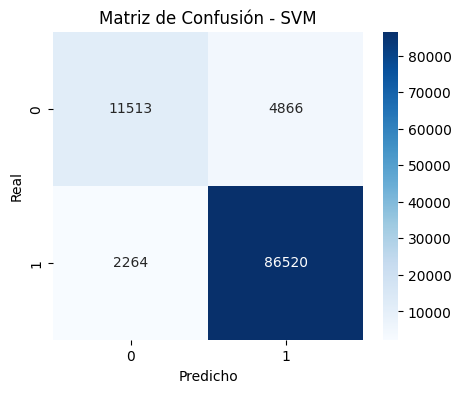


Reporte de Clasificación - SVM:
              precision    recall  f1-score   support

           0       0.84      0.70      0.76     16379
           1       0.95      0.97      0.96     88784

    accuracy                           0.93    105163
   macro avg       0.89      0.84      0.86    105163
weighted avg       0.93      0.93      0.93    105163



In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# --- Diccionario para almacenar resultados ---
resultados = {}

# --- Modelo 1: Naive Bayes ---
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
y_pred_nb = nb.predict(X_test_tfidf)
resultados['Naive Bayes'] = {
    'Accuracy': accuracy_score(y_test, y_pred_nb),
    'F1': f1_score(y_test, y_pred_nb),
    'Predicciones': y_pred_nb
}

# --- Modelo 2: Regresión Logística ---
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_tfidf, y_train)
y_pred_lr = lr.predict(X_test_tfidf)
resultados['Logistic Regression'] = {
    'Accuracy': accuracy_score(y_test, y_pred_lr),
    'F1': f1_score(y_test, y_pred_lr),
    'Predicciones': y_pred_lr
}

# --- Modelo 3: SVM ---
svm = LinearSVC()
svm.fit(X_train_tfidf, y_train)
y_pred_svm = svm.predict(X_test_tfidf)
resultados['SVM'] = {
    'Accuracy': accuracy_score(y_test, y_pred_svm),
    'F1': f1_score(y_test, y_pred_svm),
    'Predicciones': y_pred_svm
}

# --- Resultados comparativos ---
print("Resultados comparativos:\n")
for modelo, metrics in resultados.items():
    print(f"{modelo} -> Accuracy: {metrics['Accuracy']:.4f}, F1: {metrics['F1']:.4f}")

# --- Matrices de confusión individuales ---
for modelo, metrics in resultados.items():
    cm = confusion_matrix(y_test, metrics['Predicciones'])
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Matriz de Confusión - {modelo}")
    plt.xlabel("Predicho")
    plt.ylabel("Real")
    plt.show()

# --- Reporte detallado del mejor modelo (SVM) ---
print("\nReporte de Clasificación - SVM:")
print(classification_report(y_test, resultados['SVM']['Predicciones']))

# ===============================================================
# 6. ANÁLISIS EXPLORATORIO DE DATOS (EDA): DISTRIBUCIÓN DE PUNTAJES
# ===============================================================

Dimensiones: (525814, 4)

Columnas:
 Index(['Text', 'Score', 'label', 'clean_text'], dtype='object')

Valores nulos por columna:
 Text          0
Score         0
label         0
clean_text    0
dtype: int64

Distribución de 'Score':
Score
5    363122
4     80655
1     52268
2     29769
Name: count, dtype: int64


/tmp/ipython-input-2545730338.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Score', data=df, palette='viridis')


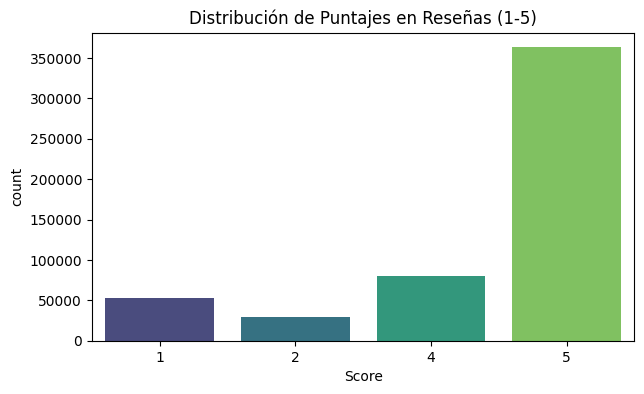

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Información general del dataset
print("Dimensiones:", df.shape)
print("\nColumnas:\n", df.columns)
print("\nValores nulos por columna:\n", df.isnull().sum())

# Estadísticas básicas del puntaje
print("\nDistribución de 'Score':")
print(df['Score'].value_counts())

# Visualización de la distribución de puntajes
plt.figure(figsize=(7,4))
sns.countplot(x='Score', data=df, palette='viridis')
plt.title('Distribución de Puntajes en Reseñas (1-5)')
plt.show()


# ===============================================================
# 7. CREACIÓN DE ETIQUETAS DE SENTIMIENTO Y VERIFICACIÓN DE DISTRIBUCIÓN
# ===============================================================

Sentiment
1    443777
0     82037
Name: count, dtype: int64


/tmp/ipython-input-1369572488.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment', data=df, palette='coolwarm')


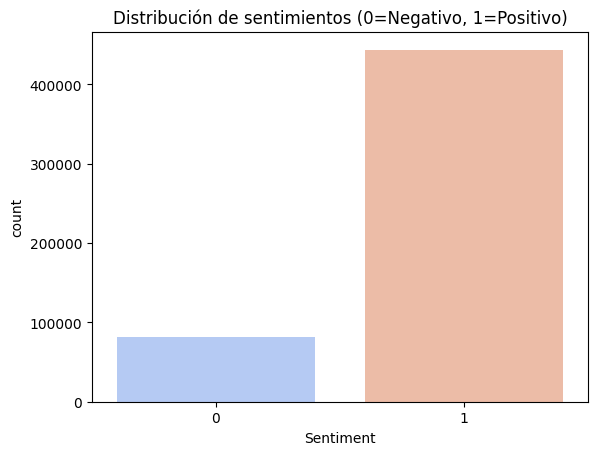

,Text,Sentiment
0,I have bought several of the Vitality canned d...,1
1,Product arrived labeled as Jumbo Salted Peanut...,0
2,This is a confection that has been around a fe...,1
3,If you are looking for the secret ingredient i...,0
4,Great taffy at a great price. There was a wid...,1


In [ ]:
# Eliminamos filas sin texto
df = df.dropna(subset=['Text'])

# Creamos una nueva columna 'Sentiment'
# 1 → positiva (Score >= 4), 0 → negativa (Score <= 2)
df = df[df['Score'] != 3]  # quitamos los neutros
df['Sentiment'] = df['Score'].apply(lambda x: 1 if x > 3 else 0)

# Verificamos distribución
print(df['Sentiment'].value_counts())
sns.countplot(x='Sentiment', data=df, palette='coolwarm')
plt.title('Distribución de sentimientos (0=Negativo, 1=Positivo)')
plt.show()

# Mostramos muestra de texto
df[['Text', 'Sentiment']].head()

# ===============================================================
# 8. REDUCCIÓN DE DIMENSIONALIDAD Y VISUALIZACIÓN CON t-SNE
# ===============================================================

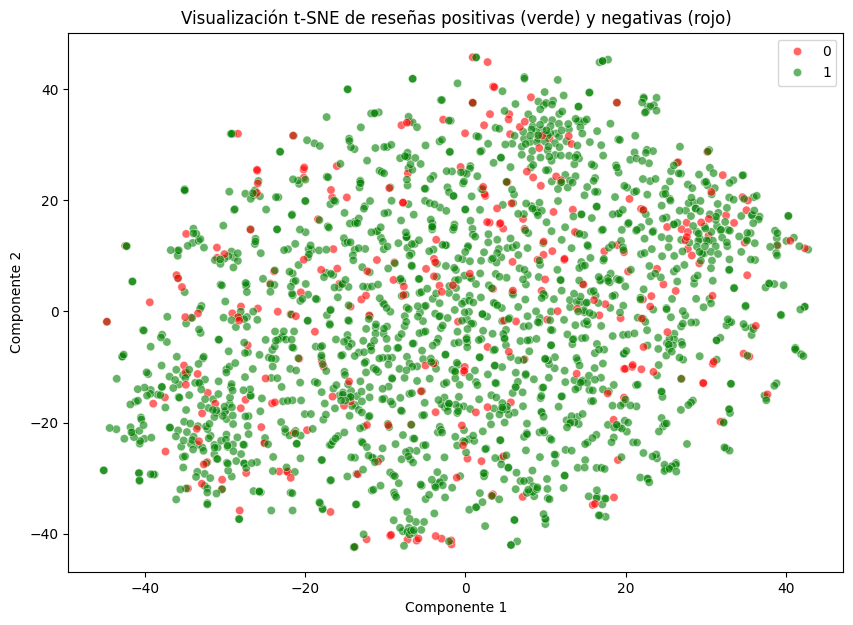

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Tomamos una muestra aleatoria para visualizar (por rendimiento)
sample_size = 2000
indices = random.sample(range(len(X_test_tfidf.toarray())), sample_size)

X_embedded = TSNE(n_components=2, random_state=42, perplexity=40).fit_transform(X_test_tfidf[indices].toarray())
y_sample = y_test.iloc[indices].values

# Gráfico
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=X_embedded[:,0], y=X_embedded[:,1],
    hue=y_sample,
    palette={0: "red", 1: "green"},
    alpha=0.6
)
plt.title("Visualización t-SNE de reseñas positivas (verde) y negativas (rojo)")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.show()


# ===============================================================
# 9. EVALUACIÓN GRÁFICA CON CURVAS ROC Y ÁREA BAJO LA CURVA (AUC)
# ===============================================================

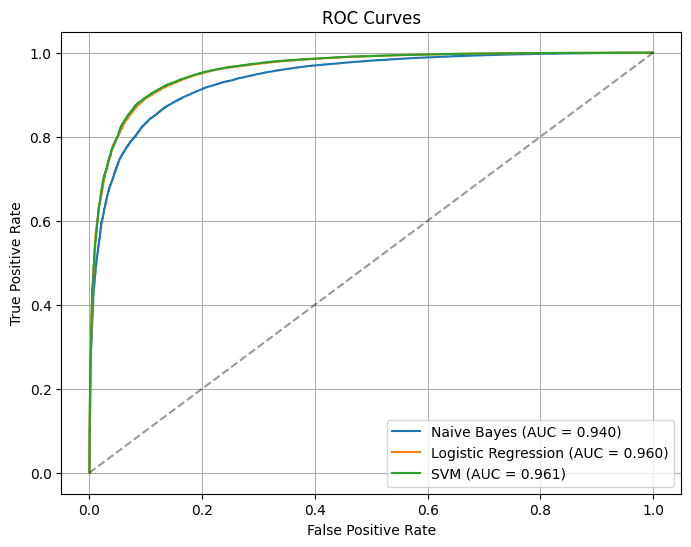

AUCs -> NB: 0.9400, LR: 0.9596, SVM: 0.9605


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

# Naive Bayes (usa predict_proba)
y_score_nb = nb.predict_proba(X_test_tfidf)[:,1]
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_score_nb)
auc_nb = auc(fpr_nb, tpr_nb)
plt.plot(fpr_nb, tpr_nb, label=f'Naive Bayes (AUC = {auc_nb:.3f})')

# Logistic Regression (predict_proba)
y_score_lr = lr.predict_proba(X_test_tfidf)[:,1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_score_lr)
auc_lr = auc(fpr_lr, tpr_lr)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.3f})')

# SVM (LinearSVC -> decision_function)
y_score_svm = svm.decision_function(X_test_tfidf)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_score_svm)
auc_svm = auc(fpr_svm, tpr_svm)
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {auc_svm:.3f})')

plt.plot([0,1],[0,1],'k--',alpha=0.4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print("AUCs -> NB: {:.4f}, LR: {:.4f}, SVM: {:.4f}".format(auc_nb, auc_lr, auc_svm))

# ===============================================================
# 10. REDUCCIÓN DE DIMENSIONALIDAD CON TruncatedSVD
# ===============================================================

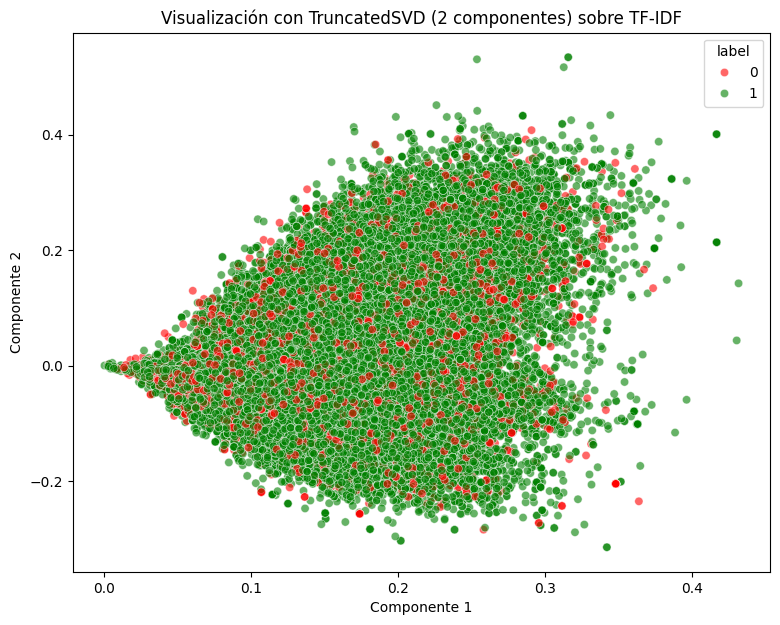

In [ ]:
from sklearn.decomposition import TruncatedSVD
import numpy as np

# Reducir TF-IDF a 2 componentes directamente con TruncatedSVD (sparse-friendly)
svd = TruncatedSVD(n_components=2, random_state=42)
X_svd = svd.fit_transform(X_test_tfidf)

plt.figure(figsize=(9,7))
sns.scatterplot(x=X_svd[:,0], y=X_svd[:,1], hue=y_test, palette={0:'red',1:'green'}, alpha=0.6)
plt.title('Visualización con TruncatedSVD (2 componentes) sobre TF-IDF')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.show()

####Descripción del Problema

Clasificar reseñas de productos alimenticios en Amazon como positivas o negativas a partir del texto de la reseña. Se usa el dataset Amazon Fine Food Reviews (Reviews.csv). Este ejercicio evalúa limpieza de texto, extracción de características (TF-IDF), entrenamiento de modelos supervisados y análisis de resultados.

- Naive Bayes (MultinomialNB): Es eficiente y robusto para texto con representación Bag-of-Words/TF-IDF; buen baseline.

- Logistic Regression: Modelo lineal con probabilidad bien calibrada; permite regularización y suele ser competitivo en tareas de clasificación de texto.

- SVM (LinearSVC): Potente para clasificación lineal en espacios de alta dimensión (como TF-IDF); suele dar buena generalización cuando las clases son separables por un hiperplano.

Por qué estos 3:

1. Cubren enfoques probabilísticos (NB),
2. Lineales probabilísticos con regularización (LR) y
3. Margen máximo (SVM).

Esto permite comparar distintos supuestos y comportamiento en el dataset.

####Resultados y métricas

Resultados principales:
- SVM obtuvo mejor F1 (0.9604) y Accuracy (0.9322).
- Logistic Regression quedó cercano (F1 0.9597).
- Naive Bayes, aunque más rápido, tuvo desempeño inferior.

Las matrices de confusión muestran mayor dificultad para clasificar la clase negativa (menor recall) debido a desbalance.

####Conclusiones

El proyecto permitió construir un sistema de clasificación de sentimientos aplicado a reseñas de alimentos en Amazon.
A través de un flujo que incluyó limpieza de texto, vectorización TF-IDF y el uso de tres modelos supervisados (Naive Bayes, Logistic Regression y SVM), se logró identificar con gran precisión las reseñas positivas y negativas escritas por los usuarios.

Los resultados mostraron que el modelo SVM fue el más efectivo, alcanzando la mayor accuracy y F1-score (≈ 0.93 y 0.96 respectivamente).
Logistic Regression obtuvo un rendimiento casi idéntico, mientras que Naive Bayes, aunque más rápido, presentó un descenso notable en la detección de comentarios negativos.

Este comportamiento puede explicarse por la naturaleza lineal del texto TF-IDF: tanto la regresión logística como el SVM explotan mejor la estructura de los datos, mientras que Naive Bayes simplifica demasiado las dependencias entre palabras.

Las matrices de confusión revelaron que el modelo tiende a clasificar erróneamente reseñas negativas como positivas, lo que refleja el desequilibrio del dataset (mayoría de reseñas con 4 o 5 estrellas).
Aun así, la capacidad del modelo para identificar correctamente las opiniones positivas es sobresaliente, confirmando que el lenguaje entusiasta (“love”, “excellent”, “delicious”) tiene patrones muy consistentes.

El análisis de ROC curves confirmó que los tres modelos aprenden correctamente la relación entre características y etiquetas, aunque SVM y Logistic Regression muestran curvas más altas y estables, indicando una mejor calibración en la predicción.
Las áreas bajo la curva (AUC) refuerzan esta superioridad: ambos modelos mantienen una tasa de verdaderos positivos alta incluso con umbrales exigentes.

Las visualizaciones mediante t-SNE y TruncatedSVD muestran que las reseñas positivas y negativas tienden a ocupar regiones diferentes en el espacio vectorial, aunque con cierta superposición.
Esto sugiere que la polaridad está bien representada por las palabras, pero el lenguaje de las reseñas —a menudo informal, ambiguo o mixto— introduce zonas de intersección inevitables.

En conjunto, los resultados demuestran que las opiniones de los consumidores sobre alimentos tienen patrones lingüísticos claros y detectables mediante técnicas clásicas de Machine Learning.
El pipeline desarrollado, aun sin recurrir a modelos neuronales, logra un desempeño sólido, interpretabilidad alta y un balance ideal entre precisión y eficiencia.